In [29]:
from pathlib import Path
import os
import pandas as pd
import pickle
import numpy as np
from influence.plotting import plot_joint_trajectory, PlotArgs

In [11]:
# First let's just figure out where everything is
base_dir = Path(
    os.path.expanduser(
        '~/influence-shaping/results/01_05_2025/yabby/31_more_circles/1x1/'
    )
)
difference_dir = base_dir / 'Difference-no-preservation'
dynamic_influence_dir = base_dir / 'D-Indirect-Timestep-no-preservation'

In [12]:
# At each trial, we need the final joint trajectory, the fitness of that joint trajectory, and the CCEA populations
class TrajInfo():
    def __init__(self, final_joint_traj_csv: Path, fitness_csv: Path, pkl: Path):
        self.df = pd.read_csv(final_joint_traj_csv)
        self.fitness = float(pd.read_csv(fitness_csv)['team_fitness_aggregated'].loc[1000])
        with open(pkl, "rb") as file:
            self.population = pickle.load(file)
        self.path = final_joint_traj_csv

In [13]:
# Round up all the joint trajectories for difference rewards at generation 1,000
trial_dirs = [trial_dir for trial_dir in os.listdir(difference_dir) if trial_dir != 'config.yaml']
trial_dirs.sort(key = lambda trial_dir : int(trial_dir.split('_')[-1]), reverse=False)
trajs = [
    TrajInfo(
        final_joint_traj_csv = difference_dir / trial_dir / 'gen_1000' / 'eval_team_0_joint_traj.csv',
        fitness_csv = difference_dir / trial_dir / 'fitness.csv',
        pkl =  difference_dir / trial_dir / 'checkpoint_1000.pkl'
    )
    for trial_dir in trial_dirs
]

In [ ]:
# For example sake, let's get a few trajectories that performed well
for traj in trajs:
    if traj.fitness > 0.9:
        print(traj.path)

/home/gonzaeve/influence-shaping/results/01_05_2025/yabby/31_more_circles/1x1/Difference-no-preservation/trial_25/gen_1000/eval_team_0_joint_traj.csv
/home/gonzaeve/influence-shaping/results/01_05_2025/yabby/31_more_circles/1x1/Difference-no-preservation/trial_30/gen_1000/eval_team_0_joint_traj.csv
/home/gonzaeve/influence-shaping/results/01_05_2025/yabby/31_more_circles/1x1/Difference-no-preservation/trial_72/gen_1000/eval_team_0_joint_traj.csv
/home/gonzaeve/influence-shaping/results/01_05_2025/yabby/31_more_circles/1x1/Difference-no-preservation/trial_78/gen_1000/eval_team_0_joint_traj.csv
/home/gonzaeve/influence-shaping/results/01_05_2025/yabby/31_more_circles/1x1/Difference-no-preservation/trial_80/gen_1000/eval_team_0_joint_traj.csv
/home/gonzaeve/influence-shaping/results/01_05_2025/yabby/31_more_circles/1x1/Difference-no-preservation/trial_96/gen_1000/eval_team_0_joint_traj.csv
/home/gonzaeve/influence-shaping/results/01_05_2025/yabby/31_more_circles/1x1/Difference-no-preserva

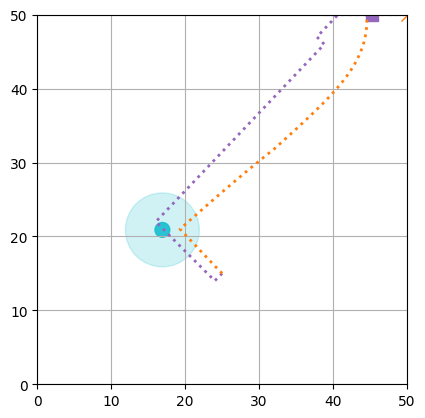

In [ ]:
# Let's plot one that performed well. Everything matches up
plot_joint_trajectory(
    joint_traj_dir=trajs[25].path, 
    individual_colors=False, 
    no_shading=False, 
    plot_args=PlotArgs()
)

In [45]:
# Let's make some kind of histogram. 
# For each trajectory, I would like to see how much the rover was influenced by the uav, and vice versa
def compute_influence_distance_based(dist, df, two_way=False):
    """ Return two lists. One is the uav's influence on the rover. The other is the rover's influence on the uav
    """
    rover_xs, rover_ys = list(df['rover_0_x']), list(df['rover_0_y'])
    rover_path = list(zip(rover_xs, rover_ys))
    
    uav_xs, uav_ys = list(df['uav_0_x']), list(df['uav_0_y'])
    uav_path = list(zip(uav_xs, uav_ys))

    uav_to_rover_influence = []
    rover_to_uav_influence = []

    for rover_position, uav_position in zip(rover_path, uav_path):
        measured_distance = np.linalg.norm( np.array(rover_position) - np.array(uav_position) )
        if measured_distance <= dist:
            uav_to_rover_val = 1
        else:
            uav_to_rover_val = 0
        if two_way:
            rover_to_uav_val = uav_to_rover_val
        else:
            rover_to_uav_val = 0

        uav_to_rover_influence.append(uav_to_rover_val)
        rover_to_uav_influence.append(rover_to_uav_val)
    
    return uav_to_rover_influence, rover_to_uav_influence

def compute_G_step_based(df, capture_radius=5.0):
    """Return one list. This list measures the inverse distance of the rover to the poi at each step.
    To reconstruct the final trajectory-based G, just take the max of this list
    """
    rover_xs, rover_ys = list(df['rover_0_x']), list(df['rover_0_y'])
    rover_path = list(zip(rover_xs, rover_ys))

    # The poi doesn't move, but get its position this way for consistency
    poi_xs, poi_ys = list(df['hidden_poi_0_x']), list(df['hidden_poi_0_y'])
    poi_path = list(zip(poi_xs, poi_ys))

    step_based_G = []
    for rover_position, poi_position in zip(rover_path, poi_path):
        measured_distance = np.linalg.norm( np.array(rover_position) - np.array(poi_position) )
        # If it's too close, then pretend the rover is 1 unit away 
        if measured_distance < 1.0:
            measured_distance = 1.0
        # Get the score for this time step
        if measured_distance <= capture_radius:
            score = float(1/measured_distance)
        else:
            score = 0.
        step_based_G.append(score)

    return step_based_G

# Let's look at the last traj
traj = trajs[-1]

uav_to_rover_influence, rover_to_uav_influence = compute_influence_distance_based(5.0, traj.df, two_way=False)
step_based_G = compute_G_step_based(traj.df)

print(uav_to_rover_influence)
print(rover_to_uav_influence)

print(step_based_G)
print(traj.fitness)
# Then a histogram of performance

# Then some way of connecting the two. Basically trying to show that if there is high influence, then there is a higher probability of high performance
# But if there is no influence, then performance is always low

[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.20279388230863177, 0.0, 0.20212829941856247, 0.23373810699798084, 0.3325135152243083, 0.3822279330158758, 0.8213612911016014, 0.5541955740029626, 0.7473918087248137, 0.36423257952772153, 0.31672536883406116, 0.24753872497374646, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.8213612911016014
